# Using raw data to generate polarization images database with rayleigh model for comparison, and figures

This code is the most important one for end user of this database. It generate an example of figures and polarimetric treatment of images of the database and generate another database with csv file. Please run it to generate "processed" database with easy-to-use csv tables and pre-processed Angle and Degree of Polarization images, with figures to visualize associated data.

Input : PolarizedDatabase folder with cropped images grouped in numpy files, you can download all or only some of the "YYYY-MM-DD_raw.npy" file days to accelerate processing on your computer.

Be careful, timestamp is local French time, which is UTC+1 in summer (like on this database), and UTC+2 on winter.

Output : PolarizedDatabaseProcessed with csv values and folders sorted by date, with subfolders for each image with a figure and AOP, DOP calculated for each sensor color, and with Rayleigh model equivalent images for comparison.

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import trange
import skimage.io
import skimage.filters
import time
from scipy.spatial.transform import Rotation as R


from tqdm import tqdm
from p_tqdm import p_map

import centroide_images
import ephemeride
import rayleigh

import csv

In [3]:
in_path="/scratch/lpoughon/PolarizedDatabase/"
calib_path="/scratch/lpoughon/PolarizedDatabase/calib/"
out_path="/scratch/lpoughon/PolarizedDatabaseProcessed/"
limit_Zenith_Angle=np.pi*0.5 #Limit Zenith Angle to crop circularly data inside of camera field-of-view.


In [4]:
def cart2sph2(x,y,z):
    """
    Input: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.
    Output: Two NumPy arrays with the n coordinates in azimuth and zenith angle, in radians, 
    using the convention that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    """
    azimuth = np.arctan2(y,x)
    zenith_angle = np.pi/2-np.arctan2(z,np.sqrt(x**2 + y**2))
    return azimuth, zenith_angle


def sph2cart2(azimuth,zenith_angle):
    """
    Input: Two NumPy arrays with n coordinates in azimuth and zenith angle, in radians, with the convention 
    that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    Output: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.

    """
    x = np.cos(np.pi/2-zenith_angle) * np.cos(azimuth)
    y = np.cos(np.pi/2-zenith_angle) * np.sin(azimuth)
    z = np.sin(np.pi/2-zenith_angle)
    return x, y, z

def average_angle(angle1,angle2):
    x=np.cos(angle1)+np.cos(angle2)
    y=np.sin(angle1)+np.sin(angle2)
    return np.arctan2(y,x)

def rebin(arr, new_shape): #https://scipython.com/blog/binning-a-2d-array-in-numpy/
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)

def calcul_Psi_Theta_Mes(centroides,x_0,y_0,f,XCoeff,YCoeff):
    theta2=(np.hypot(((centroides[:,1]-y_0)*XCoeff),((centroides[:,0]-x_0)*YCoeff))/f)
    alpha2=np.arctan2((centroides[:,0]-x_0)*YCoeff,(centroides[:,1]-y_0)*XCoeff)
    Psi_Theta_mes2=np.array([alpha2,theta2]).T
    return Psi_Theta_mes2

degrees=np.pi/180

In [5]:
#Camera color-polarization pattern
#definition of which color of the pixel is used for simple figure example

couleur=3 #is blue
# 0 : R     1 : G
# 2 : G     3 : B
#definition of which polarizer orientation is used
# indice_pol=0 is 0°
# 0 :  0°   1 : 45°
# 2 : 135°  3 : 90°
#0° -> Vertical polarization

#Load parameters from calibrations files
[crop_x_min,crop_x_max,crop_y_min,crop_y_max]=np.load(calib_path+"params_crop.npy")
(XSensor,YSensor)=(crop_x_min-crop_x_max,crop_y_max-crop_y_min) # Cropped sensor size en pixels*pixels

dist_center=np.load(calib_path+'dist_center.npy') #[1.215145972506110e+03,1.030433565024923e+03]
x_0,y_0=dist_center[0]-crop_x_min,dist_center[1]-crop_y_min #Cropped images optical center of distorsion.


eph=ephemeride.ephemerides() #Initialisation of ephemerids class to get ephemerids figure.

In [6]:
dirs = os.listdir( in_path ) # Listing Files
dirs_files=[]
for file in dirs:
    if file[-7:]=='raw.npy': # Keeping only ones with ".npy" files. 
        dirs_files.append(file)
dirs_files.sort() #We sort the files in alphabetical order. 
# Since the format is YYYY-MM-DDTHH-mm-ss.npy, the files are sorted in chronological order.


In [7]:
print(dirs_files)

['2022-07-29_raw.npy', '2022-07-30_raw.npy', '2022-07-31_raw.npy', '2022-08-01_raw.npy', '2022-08-02_raw.npy', '2022-08-03_raw.npy', '2022-08-04_raw.npy', '2022-08-05_raw.npy', '2022-08-06_raw.npy', '2022-08-07_raw.npy', '2022-08-08_raw.npy', '2022-08-09_raw.npy', '2022-08-10_raw.npy', '2022-08-11_raw.npy', '2022-08-12_raw.npy', '2022-08-13_raw.npy', '2022-08-14_raw.npy', '2022-08-15_raw.npy', '2022-08-16_raw.npy', '2022-08-17_raw.npy', '2022-08-18_raw.npy', '2022-08-19_raw.npy', '2022-08-20_raw.npy', '2022-08-21_raw.npy', '2022-08-22_raw.npy', '2022-08-23_raw.npy', '2022-08-24_raw.npy', '2022-08-25_raw.npy', '2022-08-26_raw.npy', '2022-08-27_raw.npy', '2022-08-28_raw.npy', '2022-08-29_raw.npy']


### Load one image to have an example

In [8]:
print("File used :",in_path+dirs_files[1])
images_pola=np.load(in_path+dirs_files[1],allow_pickle=True)
images_pola.shape

File used : /scratch/lpoughon/PolarizedDatabase/2022-07-30_raw.npy


(727, 4)

[array([[16, 16, 16, ..., 48, 16, 16],
        [16, 64, 16, ..., 48, 48, 32],
        [32, 64, 16, ..., 16, 32, 16],
        ...,
        [64, 48, 32, ..., 16, 48, 64],
        [16, 16, 16, ..., 80, 16, 16],
        [80, 32, 16, ..., 16, 16, 32]], dtype=uint16) 33.456
 '2022-07-30T11-40-28' 5]


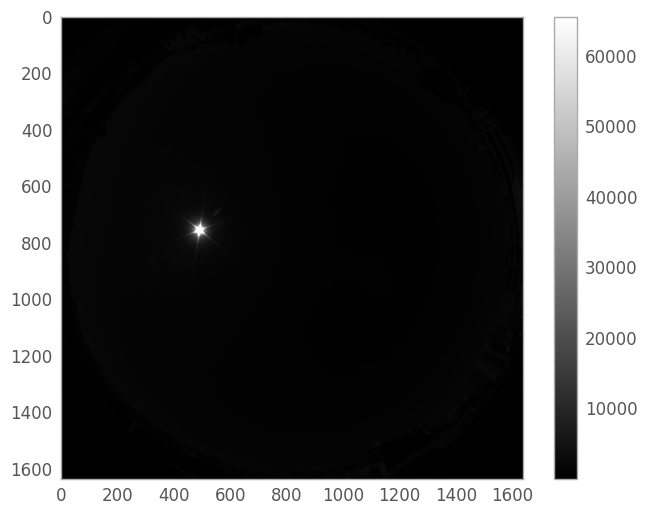

In [9]:
image_pola=images_pola[503]
image_pola=images_pola[273]

print(image_pola)
plt.imshow(image_pola[0],cmap='gray')
plt.grid(False)
plt.colorbar()



### With a right-choosen colorbar, we can also see the zones that are saturated or close to saturation threshold :

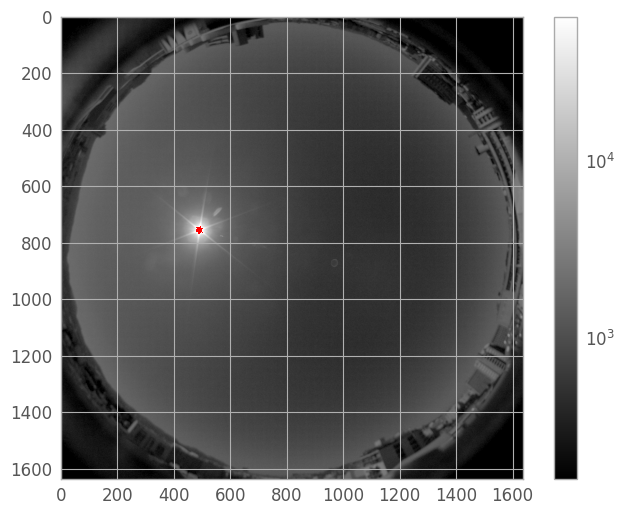

In [10]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm

image_max=65520
image_thres=65000

image=image_pola[0]

# Créer une color map personnalisée
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', [(0, 0, 0), (1, 1, 1)], N=65520)
# Créer une figure et un axe
fig, ax = plt.subplots()

# Créer une image avec des valeurs aléatoires entre 0 et 65519
#image = np.random.randint(0, 65520, size=(100, 100), dtype=np.uint16)

# Afficher l'image avec la color map personnalisée
im = ax.imshow(image, cmap=cmap,norm=LogNorm())



# Set the color of the maximum value to red
im.set_clim(vmin=160, vmax=image_thres)
im.cmap.set_over('red')

# Ajouter une colorbar
cbar = plt.colorbar(im, ax=ax)
# Afficher la figure
plt.show()

In [11]:
theta=np.load(calib_path+"theta_crop.npy")
alpha=np.load(calib_path+"alpha_crop.npy")
f=float(np.load(calib_path+"f.npy"))
rot_mat=np.load(calib_path+"rot_mat.npy")
print(theta.shape)
print(alpha.shape)

(1636, 1636)
(1636, 1636)


### A clarification about Angle of Polarization definition

Angle of Polarization is defined in regard to a reference. In the IEEE article macro-pixel description (conform to the camera documentation), vertical AoP is 90°.
In this code, we chose to have vertical polarization = 0°

The underlying image is an image of a color test target with rectangular pieces of polarizers glued on it, with transmitting linear polarization axis being aligned with the long side.

Sometimes the images are shown upside down for the purpoise of having a 0,0 axis on bottom left of image, sometimes not. These images allow to clarify in what direction the angle of polarization rotates.

In [12]:
def I_RGB_AOP(image_pola,couleur=0,yshift=False):
    """
    Plot polarized image as RGB and AOP of a chosen color, and eventually show them upside down
    """
    crop_zone=np.load(calib_path+"params_crop.npy")
    fig, (ax,ax2) = plt.subplots(1,2,gridspec_kw={'width_ratios':[0.95,1.2]})  
    image=image_pola[0].astype('int64')[crop_zone[0]:crop_zone[1],crop_zone[2]:crop_zone[3]]
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    imageRGB = (np.stack([a[0::2, 0::2], 0.5 * (a[0::2, 1::2] + a[1::2, 0::2]), a[1::2, 1::2]], axis=2) / 65520.0).astype('float32') * 255
    imageRGB=imageRGB.astype('uint8')
    im = ax.imshow(imageRGB)
    ax.set_title("RGB")
    Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
    U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
    I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
    ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
    pcm1=ax2.pcolormesh(ksi,cmap='hsv',vmin=-90.0, vmax=90.0)
    ax2.set_title("AOP - "+str(["R","Gr","Gb","B"][couleur]))#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
    cbar=fig.colorbar(pcm1,ax=ax2,shrink=0.55)
    cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
    cbar.set_label("Angle of Polarization (°)")
    if not yshift:
        ax2.invert_yaxis()
    else:
        ax.invert_yaxis()
    ax2.axis('scaled')
    ax.grid(False)
    
def I_pola_couleurs(image_pola,yshift=False):
    crop_zone=np.load(calib_path+"params_crop.npy")
    #fig, ax = plt.subplots()  
    image=image_pola[0].astype('int64')[crop_zone[0]:crop_zone[1],crop_zone[2]:crop_zone[3]]
    expo=image_pola[1] 
    chainetps=image_pola[2]
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    #image=image_pola[0].astype('int64')

    
    
    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])
        
    #Calculation of stokes parameters and of AOP and DOP    
    #Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
    #U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
    #I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
            
    print("Creation figure ...")
    fig,(ax0,ax1,ax2,ax3)=plt.subplots(4,4,figsize=(12,12),gridspec_kw={'width_ratios':[1,1,1,1]})

    #plt.suptitle("Image : "+chainetps[:-1]+ " ~ Color channel :  "+str(["R","Gr","Gb","B"][couleur])+" ~ Expo : "+str(expo)+" µs")
            
    
    for couleur in range(4):
        # Processing AOP and DOP for each color and saving it, and plot it
  
        #AOP values calculation
        I0=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
        I90=image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
        I45=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
        I135=image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
        
        
        for pola in range(4):
            j,i=((couleur//2)*2+pola//2),((couleur%2)*2+pola%2)
            ax_pola=[ax0,ax1,ax2,ax3][i][j] #j column, i line
            #ax_pola.imshow([I0,I45,I135,I90][pola],cmap='gray')
            ax_pola.imshow(image[i::4,j::4],cmap='gray',vmin=16,vmax=20000)
            ax_pola.set_title("img["+str(i)+"::4,"+str(j)+"::4] ("+["0°","45°","135°","90°"][pola]+","+str(["R","Gr","Gb","B"][couleur])+")")
            if yshift:
                ax_pola.invert_yaxis()
            ax_pola.axis('scaled')
            ax_pola.grid(False)
                  
    #plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)
    plt.suptitle('Sub-pictures sliced in Numpy array "img", \n with convention that 0° is vertical polarization')
    plt.suptitle('Sous-images "slicées" dans le tableau Numpy "img", \n avec la convention que 0° correspond à la polarisation verticale')

    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.25,hspace=0.25)

### A test np array to see how is it plotted

A : 
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
 
A[0::4,1::4] : 
[[1]]


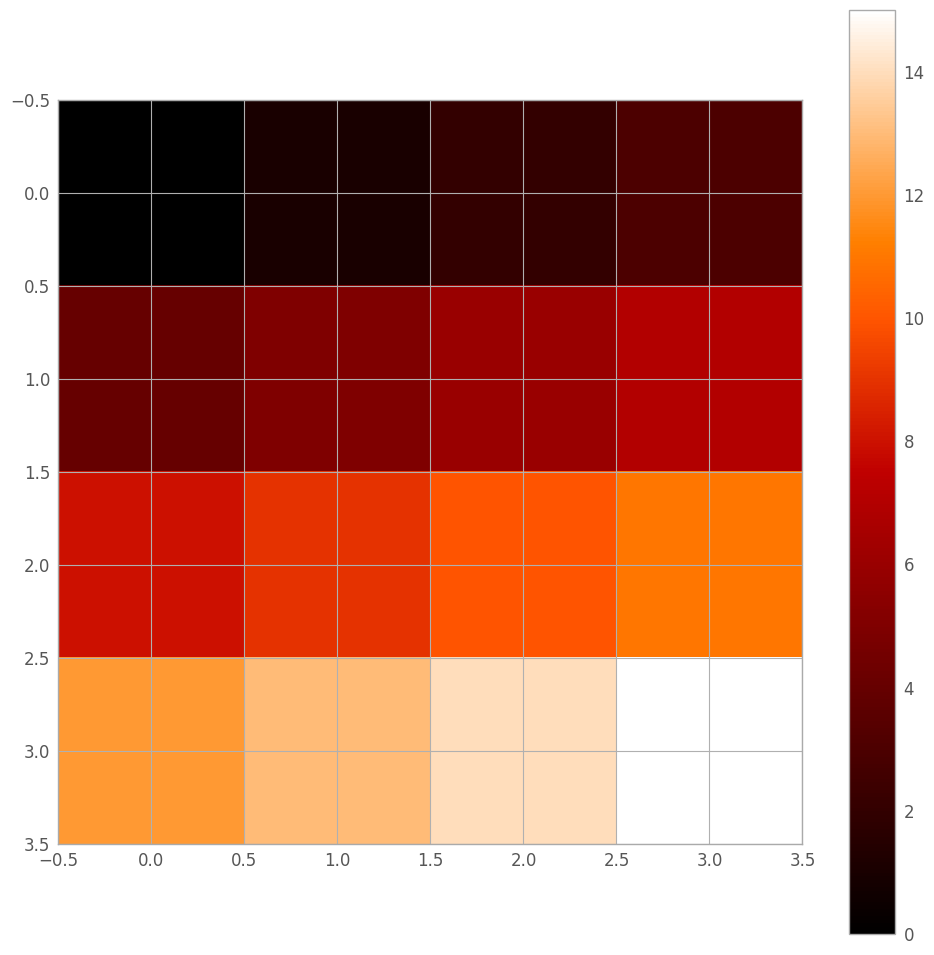

In [13]:
A=np.array([[0,1,2,3],[4,5,6,7],[8,9,10,11],[12,13,14,15]])
print("A : ")
print(A)
print(" ")
print("A[0::4,1::4] : ")
print(A[0::4,1::4])
plt.figure(figsize=(12,12))
plt.imshow(A)
plt.colorbar()

Then we can plot each sub-picture sliced from the whole one, keeping only one color-polarization pixel type :

Creation figure ...


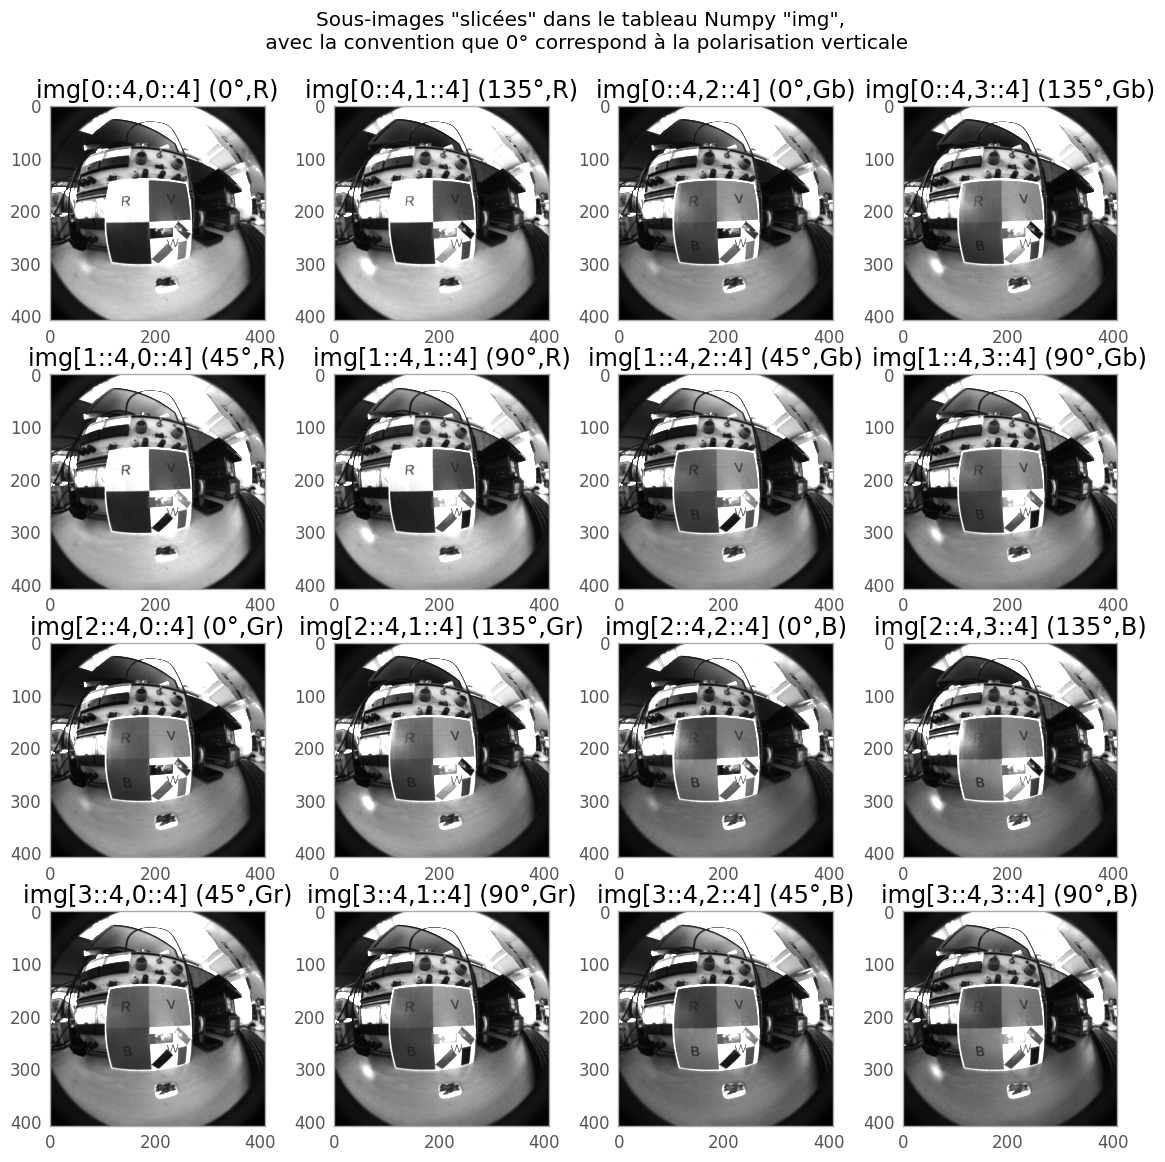

In [14]:
image_pola_test=image_pola.copy()

image_pola_test[0]=np.load("test_mire_rgb_pola_.npy")
I_pola_couleurs(image_pola_test) 

Then we can compare with processed RGB and AOP :

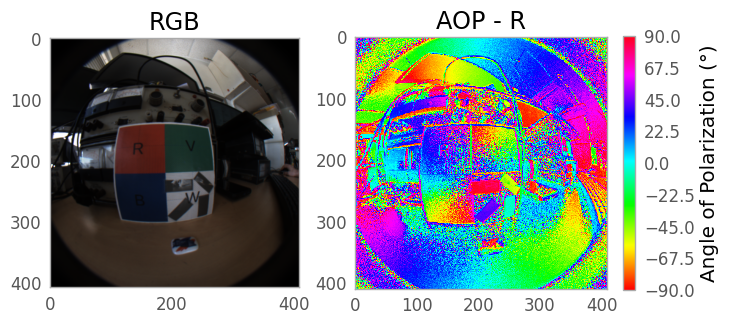

In [15]:
I_RGB_AOP(image_pola_test,yshift=False)

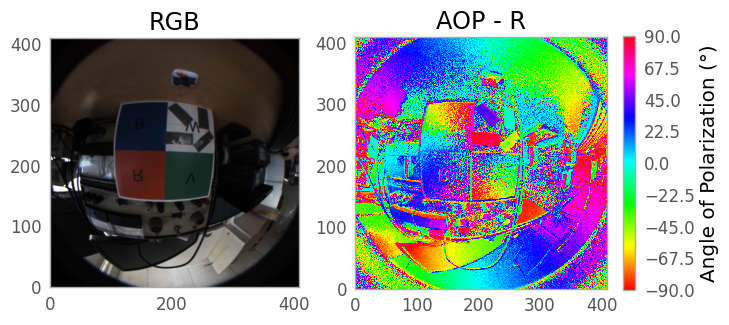

In [16]:
I_RGB_AOP(image_pola_test,yshift=True)

### Generate a figure like the one in IEEE conference article :
#### https://ieeexplore.ieee.org/document/10325176
#### https://hal.science/hal-04267766

In [16]:
theta_0=theta[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]
theta_90=theta[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]
theta_45=theta[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]
theta_135=theta[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]
theta_mini=average_angle(average_angle(theta_0,theta_90),average_angle(theta_45,theta_135))


def generate_IEEE_conference_article_figure(image_pola):    
    eph=ephemeride.ephemerides() #Initialization of the function used for calculating ephemerides.
    expo=image_pola[1] 
    chainetps=image_pola[2]
    
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) # Calculation of the ephemeris at the time of capture.
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps) 
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')

    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])
        
    #Calculation of stokes parameters and of AOP and DOP    
    Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
    U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
    I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
    ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
    ksi[theta_mini>limit_Zenith_Angle]=0
            
    print("Creation figure ...")
    fig,(ax1,ax2)=plt.subplots(2,3,figsize=(20,12),gridspec_kw={'width_ratios':[0.95,1.2,1.2]})

    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Color channel :  "+str(["R","Gr","Gb","B"][couleur])+" ~ Expo : "+str(expo)+" µs")
            
            
    print("plot aop image...")
    pcm1=ax2[1].pcolormesh(ksi,cmap='hsv')
    ax2[1].set_title("Measured AOP")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
    cbar=fig.colorbar(pcm1,ax=ax2[1],shrink=0.9)
    cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
    cbar.set_label("Angle of Polarization (°)")
    ax2[1].invert_yaxis()

    print("plot dop image...")
    DOP_dofp=np.hypot(Q,U)/I 
    DOP_dofp[theta_mini>limit_Zenith_Angle]=0
    pcm3=ax2[2].pcolormesh(np.minimum(DOP_dofp,1),cmap='jet',vmin=0.0, vmax=1.0)
    ax2[2].set_title("Measured DOP")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
    cbardop=fig.colorbar(pcm3,ax=ax2[2],shrink=0.9)
    pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
    cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
    cbardop.set_label("Degree of Polarization")
    ax2[2].invert_yaxis()

    print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    imageRGB = (np.stack([a[0::2,0::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]], axis=2)/65520.0*255).astype('uint8')
    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax2[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax2[0],shrink=0.9)
    ax2[0].set_aspect('equal')
      
    d=np.pi/180
    r = R.from_matrix(rot_mat)
            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    #x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
 
            
    ax2[0].set_title("RGB Image")                 
    print("plot ephemeride...")
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax1[0])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
            
    print("plot simul rayleigh...")
    
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax1[1],ax_dop=ax1[2],fig=fig,Psi=alpha,Theta=theta,rot_mat=rot_mat,limit_Zenith_Angle=limit_Zenith_Angle)#orientation_pixels_ENU=orientation_ENU)

    ax2[1].invert_yaxis()
    ax2[2].invert_yaxis()            

          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)
    ax2[0].axis('scaled')
    ax2[1].axis('scaled')
    ax2[2].axis('scaled')
    ax1[1].axis('scaled')
    ax1[2].axis('scaled')
    cbarrgb.remove()
    return (U,Q,I,ksi,DOP_dofp,fig)

Creation figure ...
plot aop image...
plot dop image...
plot rgb image...
Psi_sun : 2.1560233585276607 Theta_sun : 0.6306113071824763
Sun_rot[0] : -0.24496746536974776 Sun_rot[1] : 0.5956746854486658
plot ephemeride...
plot simul rayleigh...


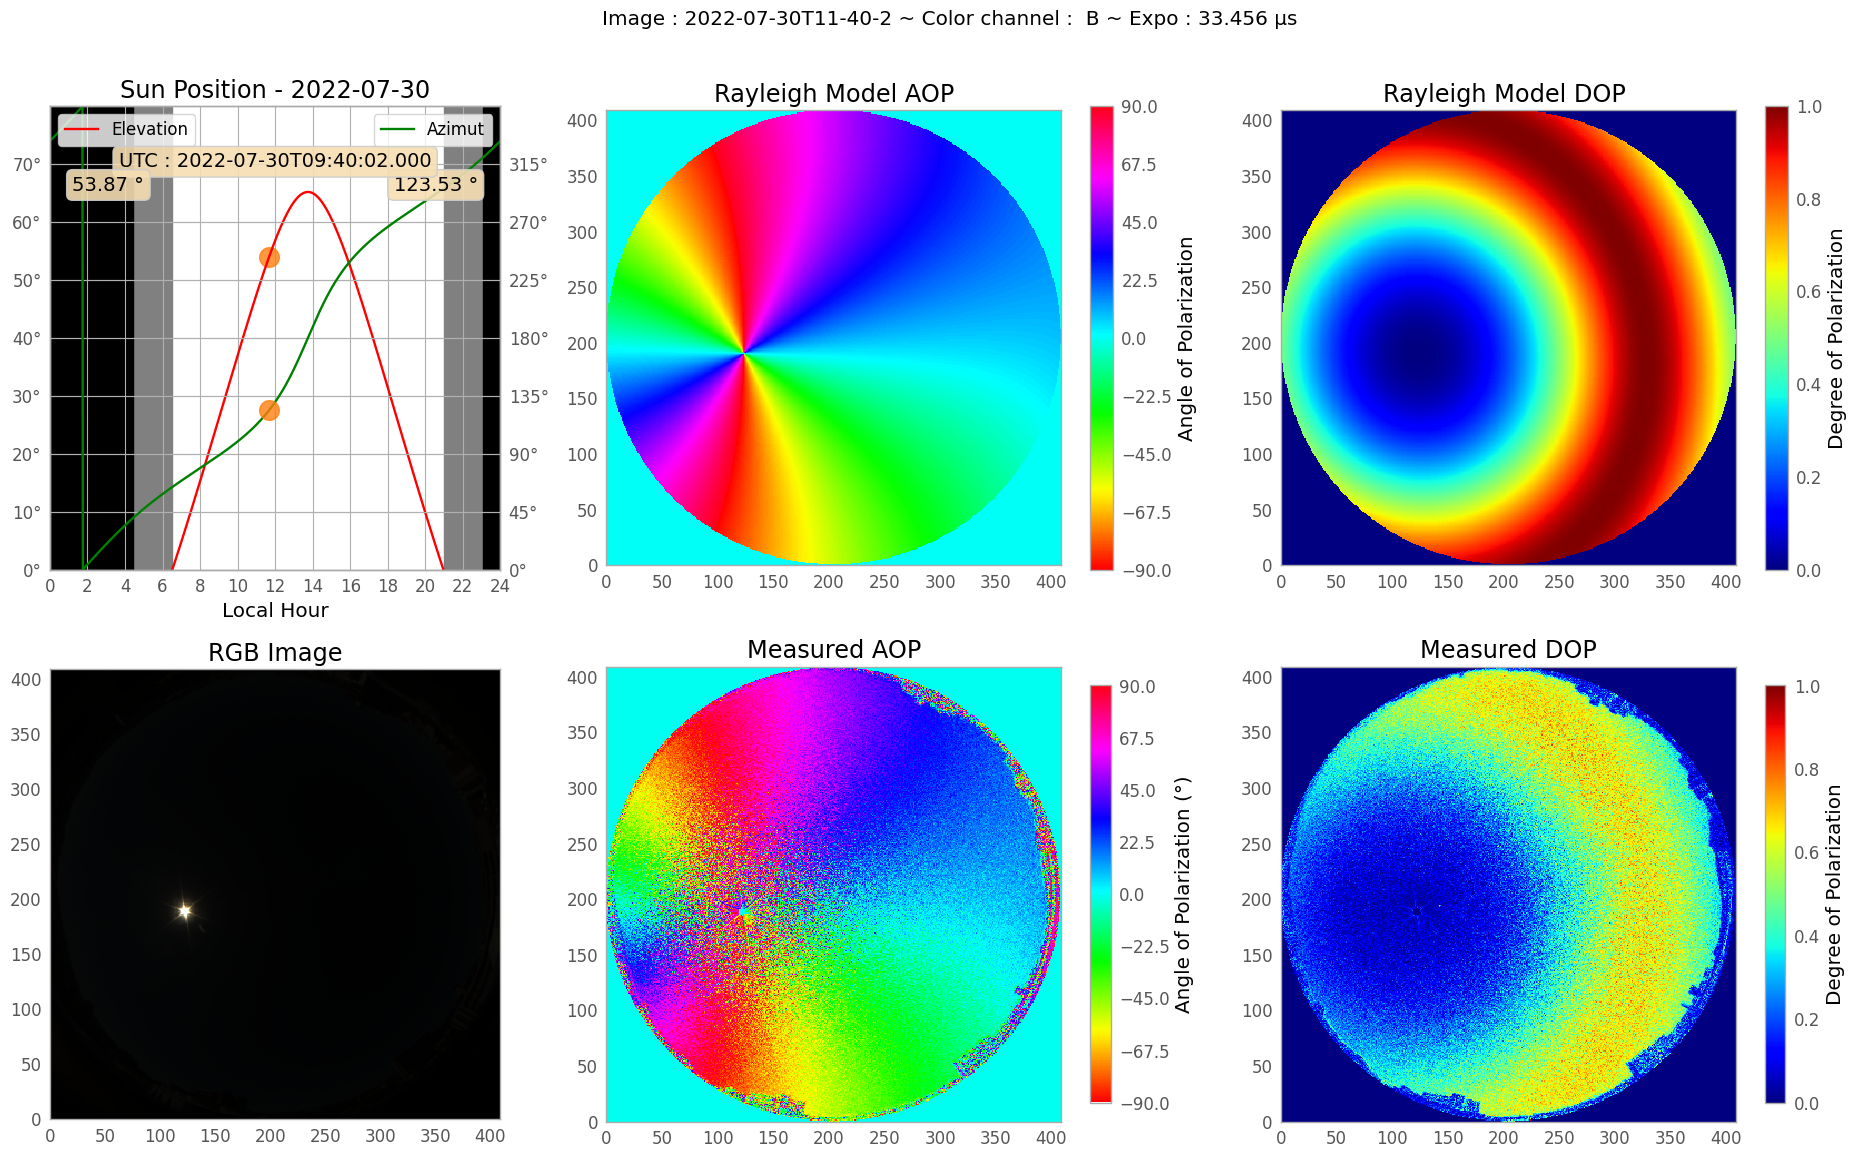

In [17]:
U,Q,I,A,D,mafig=generate_IEEE_conference_article_figure(image_pola)

In [18]:
mafig.savefig("test_figure.png")

In [19]:
mafig.show()

In [20]:
np.seterr(divide='ignore', invalid='ignore')  # Ignore division by zero and invalid value warnings

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### Calculation of AOP/DOP figure and values for each color, with Rayleigh simulation

In [21]:
def AOP_DOP_process_save_and_figure(image_pola,save=True,sat_level=65500):
    verbose_text=False
    
    eph=ephemeride.ephemerides() #Initialization of the function used for calculating ephemerides.
    expo=image_pola[1] 
    chainetps=image_pola[2]
    type_image=image_pola[3]
    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps) # Calculation of the ephemeris at the time of capture.
    (Ha_sun,Dec_sun)=eph.getHADecSoleil(chainetps)
    
    chaineheure=chainetps.split("T")[1].split("-")
    chainedate=chainetps.split('T')[0]
    heure_image=ephemeride.Time(chainetps.split("T")[0]+'T'+chaineheure[0]+":"+chaineheure[1]+":"+chaineheure[2])
    image=image_pola[0].astype('int64')
    
    chemin_enreg=out_path+chainedate+'/'
    if save:
        if not os.path.exists(chemin_enreg):
            try:
                os.mkdir(chemin_enreg)
            except Exception as e:print(e)
        #if os.path.exists(chemin_enreg+chainetps):return [None]
        if not os.path.exists(chemin_enreg+chainetps):
            try:
                os.mkdir(chemin_enreg+chainetps)
            except Exception as e:print(e)
        np.save(chemin_enreg+chainetps+"/image.npy",image)

    degre_sat=np.count_nonzero(image>=65520)/(image.shape[0]*image.shape[1])

    # Here we want to calculate the "average angle" seen at the center of a macropixel. 
    # We know the orientations of each sub-pixel (theta, alpha). However, a simple average 
    # does not work for finding the "central" orientation. For instance, the "average" between 
    # two 2D vectors with angles 45° and 315° would "actually" be 0°, but the arithmetic mean of
    # the two angles is 180°. Here, we encounter the same problem when transitioning from -π to π 
    # with numerical artifacts. To avoid this, we convert back to Cartesian coordinates and use atan2.    
            
    if verbose_text:print("Creation figure ...")
    fig,(ax0,ax2,ax3)=plt.subplots(3,4,figsize=(24,20),gridspec_kw={'width_ratios':[1.2,1.2,1.2,1.2]})
    plt.suptitle("Image : "+chainetps[:-1]+ " ~ Expo : "+str(expo)+" µs")
    
    
    if verbose_text:print("plot rgb image...")
    a=rebin(image,(image.shape[0]//2,image.shape[1]//2))
    ##########################################################################
    # cv2 replaced by np.stack
    # imageRGB=(cv2.merge((a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]))/65520.0*255).astype('uint8')
    imageRGB = (np.stack([a[0::2,1::2],0.5*(a[0::2,1::2]+a[1::2,0::2]),a[1::2,1::2]], axis=2)/65520.0*255).astype('uint8')
    ##########################################################################

    x, y = np.meshgrid(np.arange(imageRGB.shape[1] + 1), np.arange(imageRGB.shape[0] + 1))

    # Plot RGB image using pcolormesh
    pc = ax0[0].pcolormesh(x, y, imageRGB, edgecolors='k', linewidths=0.0)
    cbarrgb=fig.colorbar(pc,ax=ax0[1],shrink=0.9)
    ax0[0].set_aspect('equal')
    #ax2[0].imshow(cv2.cvtColor((imageRGB.astype('float32')/255.0).astype('uint8'), cv2.COLOR_BGR2RGB))
    #ax2[0].grid(False)        
    d=np.pi/180
    r = R.from_matrix(rot_mat)

            
    Sun_rot_cart=r.apply(np.array(sph2cart2(Psi_sun*d,Theta_sun*d)).T).T
    Sun_rot=np.array(cart2sph2(Sun_rot_cart[0],Sun_rot_cart[1],Sun_rot_cart[2])).T
            #Sun_rot[0] -> Psi, (az)
            #Sun_rot[1] -> Theta, zenith = 0 (anti-elev)
    if verbose_text:print("Psi_sun : "+str(Psi_sun*degrees)+" Theta_sun : "+str(Theta_sun*degrees))
    if verbose_text:print("Sun_rot[0] : "+str(Sun_rot[0])+" Sun_rot[1] : "+str(Sun_rot[1]))
    x_sol,y_sol=np.array([(x_0+f*np.sin(Sun_rot[0])*(Sun_rot[1]))/4]),np.array([(y_0-f*np.cos(Sun_rot[0])*(Sun_rot[1]))/4])
 
            
    ax0[0].set_title("RGB Image")                 

            
    if verbose_text:print("plot ephemeride...")
    eph.traceAzELSoleil(chainetps=chainetps,Ax=ax0[1])

    (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chainetps)
                    

    for couleur in range(4):
        # Processing AOP and DOP for each color and saving it, and plot it

        #put a Nan Value on zones where at least one pixels of macropixel was saturated
        sat_zone=((image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]>sat_level) | 
                  (image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]>sat_level) |
                  (image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]>sat_level) |
                  (image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]>sat_level))

        
        #AOP values calculation
        Q=image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]-image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4] # I0-I90
        U=image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]-image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4] # I45-I135
        I=0.5*(image[((couleur//2)*2+0//2)::4,((couleur%2)*2+0%2)::4]+image[((couleur//2)*2+3//2)::4,((couleur%2)*2+3%2)::4]+image[((couleur//2)*2+1//2)::4,((couleur%2)*2+1%2)::4]+image[((couleur//2)*2+2//2)::4,((couleur%2)*2+2%2)::4]) # (I0 + I90 + I45 + I135)/2
        ksi=(0.5*np.arctan2(U,Q)*180/np.pi)
        ksi[theta_mini>limit_Zenith_Angle]=np.nan    
        ksi[sat_zone]=np.nan
        #getting right subfigure to plot it
        if couleur==0 or couleur==1 :
            ax_coul_aop=[ax2,ax3][couleur][0]
            ax_coul_dop=[ax2,ax3][couleur][1]
            if verbose_text:print(couleur)
        if couleur==2 or couleur==3 :
            ax_coul_aop=[ax2,ax3][couleur-2][2]
            ax_coul_dop=[ax2,ax3][couleur-2][3]
            if verbose_text:print(couleur)
        #ax_coul
        
        #save AOP value
        if save:np.save(chemin_enreg+chainetps+"/AOP_"+str(["R","Gr","Gb","B"][couleur])+".npy",ksi)
            
        
        #Plot it
        if verbose_text:print("plot aop image...")
        cmap_hsv = plt.cm.hsv  # You can use any colormap you prefer
        cmap_hsv.set_bad('black', alpha=1.0)
        pcm1=ax_coul_aop.pcolormesh(ksi,cmap=cmap_hsv,vmin=-90.0, vmax=90.0)
        ax_coul_aop.set_title("Measured AOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - AOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbar=fig.colorbar(pcm1,ax=ax_coul_aop,shrink=0.9)
        cbar.set_ticks([-90,-67.5,-45,-22.5,0,22.5,45,67.5,90])
        cbar.set_label("Angle of Polarization (°)")
        #ax_coul_aop.invert_yaxis()

        if verbose_text:print("plot dop image...")
        # DOP values calculation
        DOP_dofp=np.hypot(Q,U)/I 
        DOP_dofp[theta_mini>limit_Zenith_Angle]=np.nan
        DOP_dofp[sat_zone]=np.nan
        
        #save it
        if save:np.save(chemin_enreg+chainetps+"/DOP_"+str(["R","Gr","Gb","B"][couleur])+".npy",DOP_dofp)
        
        #plot it
        # Create a custom colormap with black for NaN values
        cmap_jet = plt.cm.jet  # You can use any colormap you prefer
        cmap_jet.set_bad('black', alpha=1.0)
        pcm3=ax_coul_dop.pcolormesh(np.minimum(DOP_dofp,1),cmap=cmap_jet,vmin=0.0, vmax=1.0)
        ax_coul_dop.set_title("Measured DOP"+" (color : "+str(["R","Gr","Gb","B"][couleur])+" )")#chemin.split('ManipeResultats')[1]+" - DOP - Canal "+str(["R","Gr","Gb","B"][couleur]))
        cbardop=fig.colorbar(pcm3,ax=ax_coul_dop,shrink=0.9)
        pcm3.set_clim(0, 1.0)#cbardop.vmin=0#cbardop.vmax=1
        cbardop.set_ticks([0,0.2,0.4,0.6,0.8,1])
        cbardop.set_label("Degree of Polarization")
          
        ax_coul_aop.axis('scaled')
        ax_coul_dop.axis('scaled')

            
    if verbose_text:print("plot simul rayleigh...")
    #Show rayleigh simulation and save its values
    #AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax0[2],ax_dop=ax0[3],fig=fig,Psi=alpha,Theta=theta,rot_mat=rot_mat)#orientation_pixels_ENU=orientation_ENU)
    AOP_s,DOP_s=rayleigh.simul_rayleigh_subplot((Psi_sun),Theta_sun,ax_aop=ax0[2],ax_dop=ax0[3],fig=fig,Psi=alpha,
Theta=theta,rot_mat=rot_mat,limit_Zenith_Angle=limit_Zenith_Angle,out_zone=np.nan)#orientation_pixels_ENU=orientation_ENU)


          
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.2,hspace=0.2)

    ax0[2].axis('scaled')
    ax0[3].axis('scaled')
    cbarrgb.remove()

    #save all data values in a folder        
    if save:np.save(chemin_enreg+chainetps+"/AOP_s.npy",AOP_s)
    if save:np.save(chemin_enreg+chainetps+"/DOP_s.npy",DOP_s)
    if save:np.save(chemin_enreg+chainetps+"/expo.npy",expo)
            
    if save:np.savetxt(chemin_enreg+chainetps+"/time.npy",list(map(int,chainetps[:-1].split('T')[0].split('-')+chainetps[:-1].split('T')[1].split('-'))),delimiter=',',fmt="%d") # ['YYYY', 'MM', 'DD', 'HH', 'mm', 'ss/']
    if verbose_text:print("Sauv fig...")
    if save:plt.savefig(chemin_enreg+chainetps+"/fig.png")
    if not save:plt.show()
    plt.close()
  
    return [chainedate+'/'+chainetps,chainetps,chaineheure[0],chaineheure[1],chaineheure[2],chainedate,Psi_sun,Theta_sun,Ha_sun,
                        Dec_sun,expo,type_image]


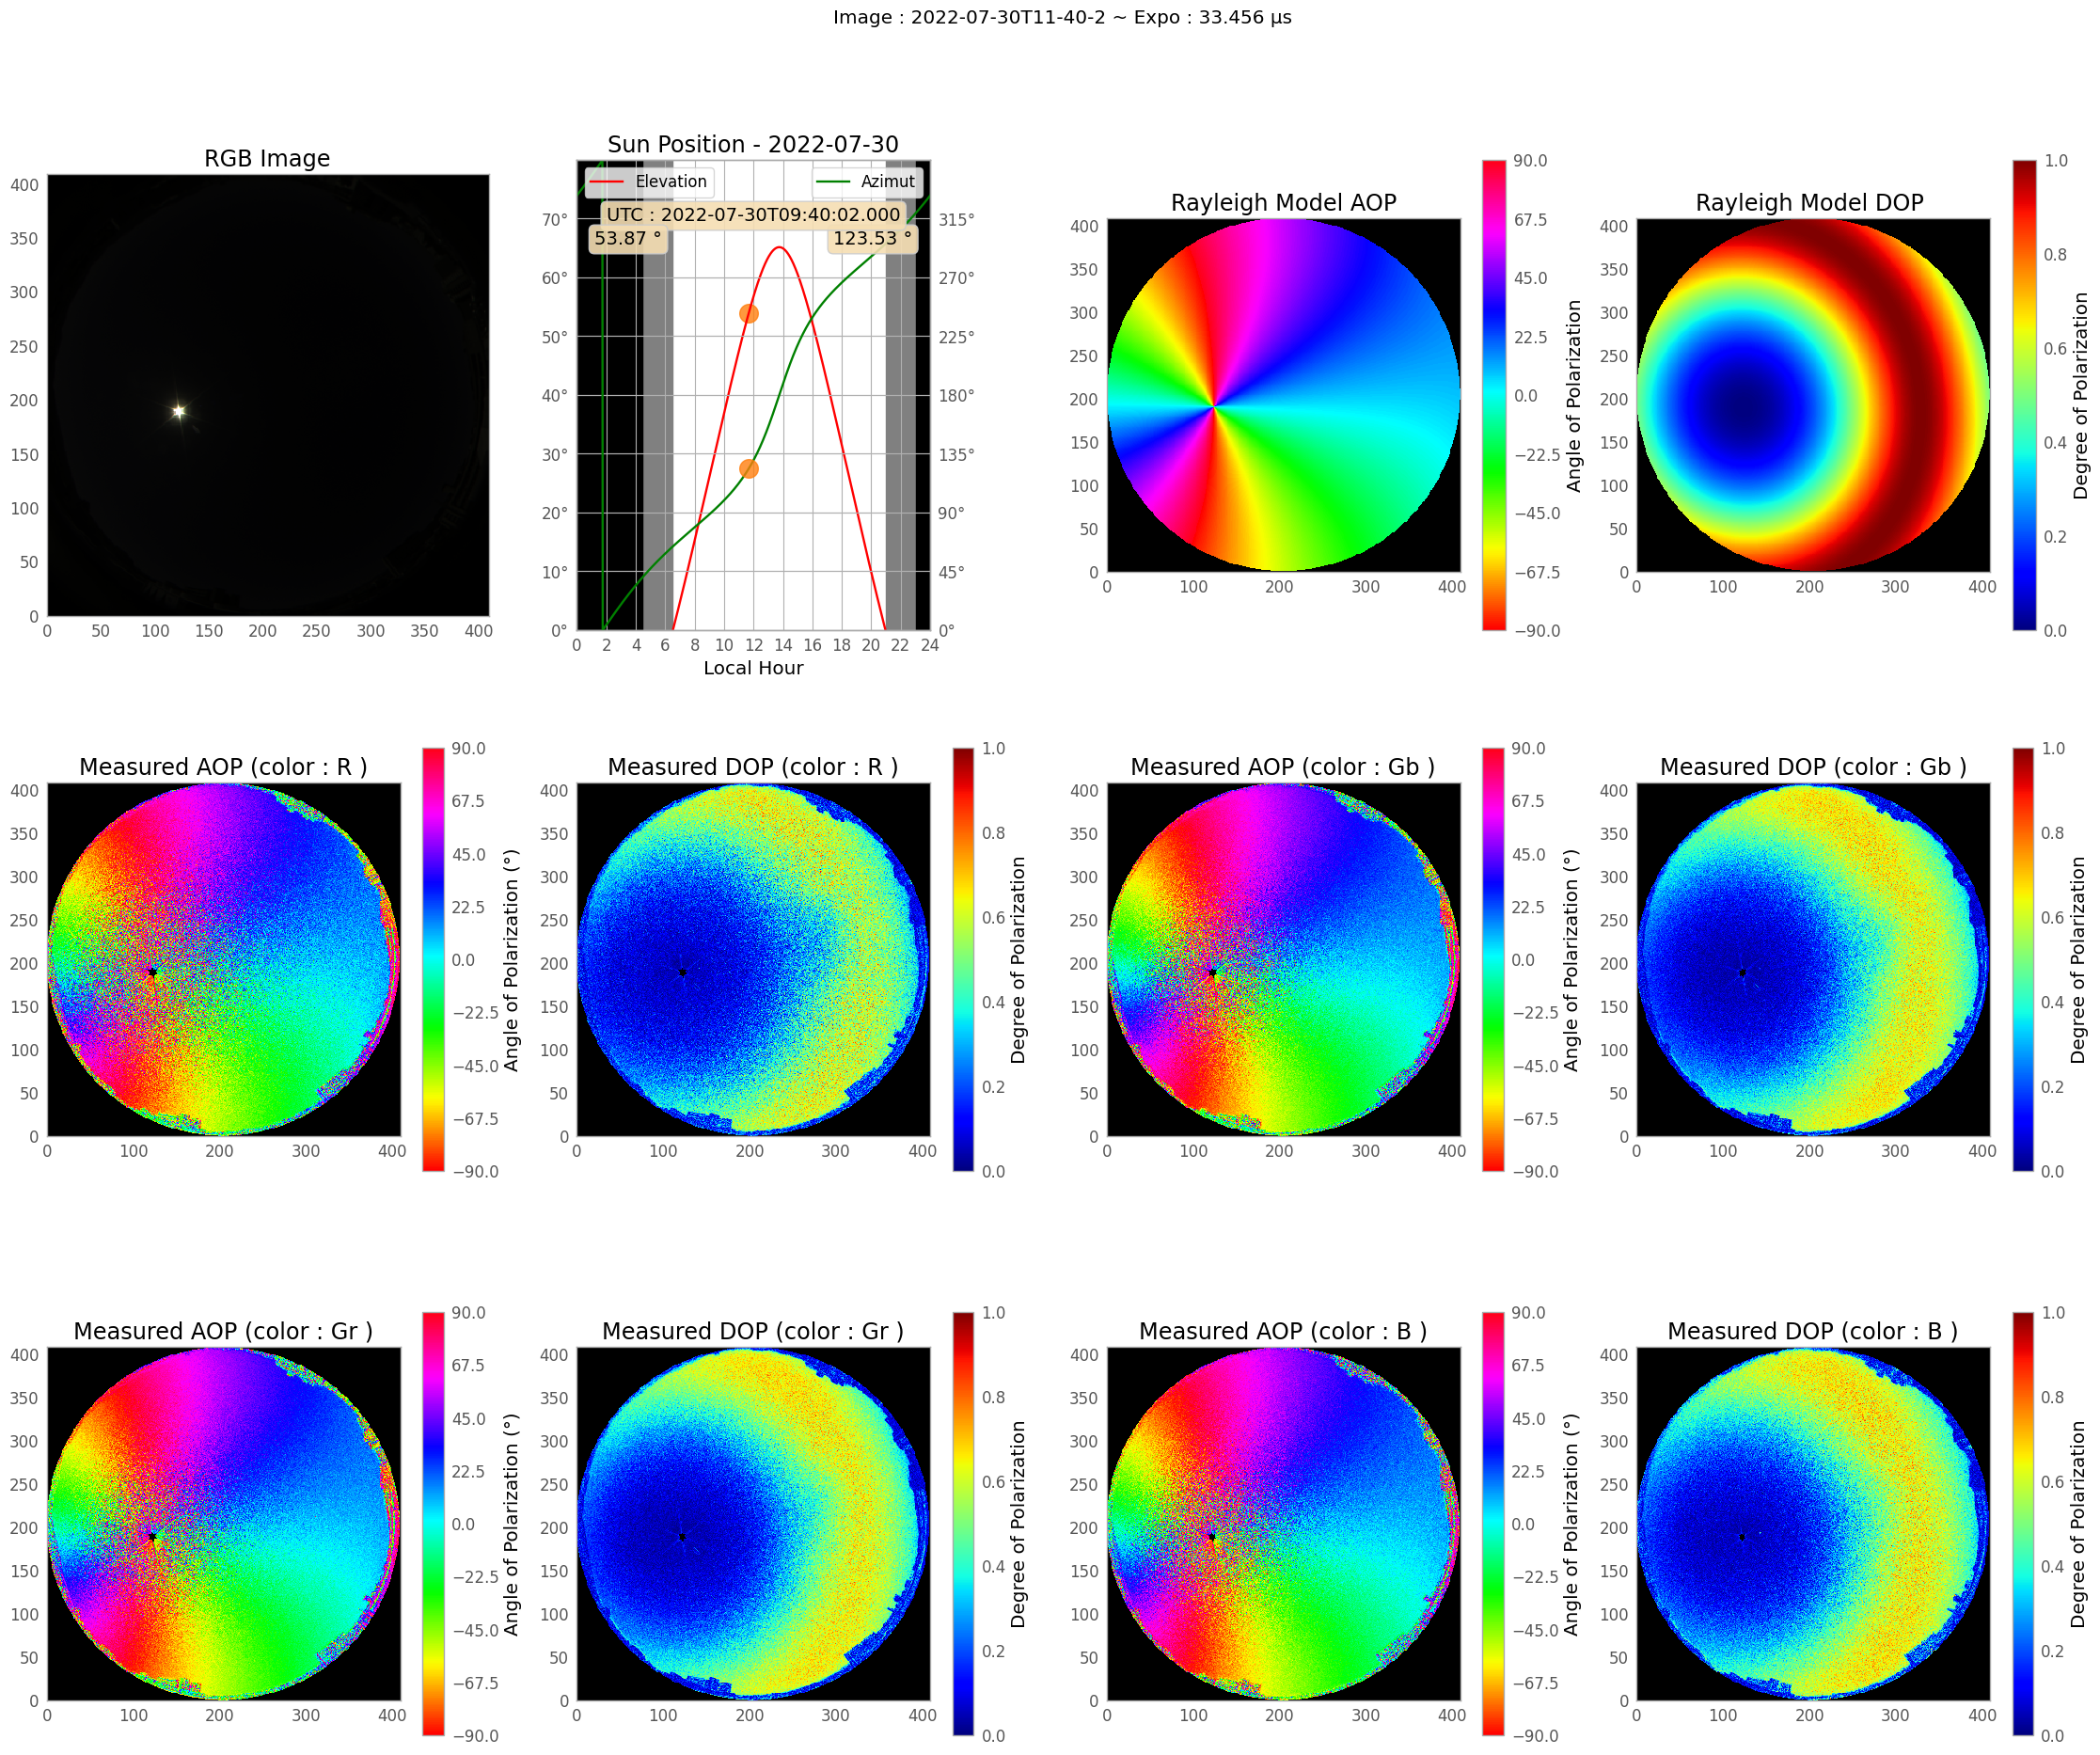

In [22]:
elt_liste=AOP_DOP_process_save_and_figure(image_pola,save=False) #show an example

### Processing for each day of database and saving into new "processed" database

In [23]:
for i in range(len(dirs_files)):
    print(i, end=" ")
    print(dirs_files[i])
    images_pola=np.load(in_path+dirs_files[i],allow_pickle=True)
    tic=time.time()
#    liste_jour=sorted_filenames_dict[key]
    #partial_process_directory_1 = partial(process_directory_1, RGB_HSV_conv=True,image_size=50)
    num_processes=32*2
    results = (p_map(AOP_DOP_process_save_and_figure ,images_pola,num_cpus=num_processes,tqdm=tqdm))
#results = np.array([sublist for sublists in results for sublist in sublists if sublist is not None])
#np.save(out_path+key+"_raw.npy",results)
    print("Elapsed Time : ",time.time()-tic)
    np.array(results).shape
    
    #Store datas in csv table
    
    # Sample data for each column


    # Specify the file name
    file_name = out_path+dirs_files[i].split("_")[0]+'.csv'

    # Write data to the CSV file
    with open(file_name, mode='w', newline='') as csv_file:
        writer = csv.writer(csv_file)

        # Write header row
        writer.writerow(['Image_folder_path', 'Timestamp', 'Hour_Local','Minute_Local','Second_Local', 
                         'Date', 'Sun_azimuth', 'Sun_zenith_angle', 'Sun_hour_angle', 'Sun_declination', 
                         'Camera_exposure_time','Image_type'])

        # Write data rows
        for row in results:
            writer.writerow(row)

    print(f"Data saved to {file_name}")
    print(" ")
    print(" ")
    print(" ")    

0 2022-07-29_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [01:49<00:00,  4.57it/s]


Elapsed Time :  118.59276247024536
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-07-29.csv
 
 
 
1 2022-07-30_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 727/727 [02:36<00:00,  4.66it/s]


Elapsed Time :  166.52411222457886
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-07-30.csv
 
 
 
2 2022-07-31_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [02:41<00:00,  4.64it/s]


Elapsed Time :  173.94698643684387
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-07-31.csv
 
 
 
3 2022-08-01_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 657/657 [02:24<00:00,  4.54it/s]


Elapsed Time :  157.25942635536194
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-01.csv
 
 
 
4 2022-08-02_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [02:40<00:00,  4.55it/s]


Elapsed Time :  174.55522441864014
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-02.csv
 
 
 
5 2022-08-03_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 711/711 [02:37<00:00,  4.50it/s]


Elapsed Time :  170.52355980873108
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-03.csv
 
 
 
6 2022-08-04_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [02:37<00:00,  4.67it/s]


Elapsed Time :  172.2008922100067
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-04.csv
 
 
 
7 2022-08-05_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 712/712 [02:33<00:00,  4.64it/s]


Elapsed Time :  166.5739119052887
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-05.csv
 
 
 
8 2022-08-06_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 748/748 [02:41<00:00,  4.65it/s]


Elapsed Time :  174.57060146331787
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-06.csv
 
 
 
9 2022-08-07_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 734/734 [02:40<00:00,  4.57it/s]


Elapsed Time :  174.62652778625488
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-07.csv
 
 
 
10 2022-08-08_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 723/723 [02:37<00:00,  4.58it/s]


Elapsed Time :  172.71364450454712
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-08.csv
 
 
 
11 2022-08-09_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 709/709 [02:36<00:00,  4.53it/s]


Elapsed Time :  170.484219789505
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-09.csv
 
 
 
12 2022-08-10_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 735/735 [02:40<00:00,  4.58it/s]


Elapsed Time :  175.70977973937988
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-10.csv
 
 
 
13 2022-08-11_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 710/710 [02:38<00:00,  4.48it/s]


Elapsed Time :  173.25151419639587
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-11.csv
 
 
 
14 2022-08-12_raw.npy


  0%|                                                                                                                                                                                      | 0/731 [00:00<?, ?it/s]

[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-12/'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 731/731 [02:39<00:00,  4.59it/s]


Elapsed Time :  174.36660432815552
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-12.csv
 
 
 
15 2022-08-13_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 726/726 [02:35<00:00,  4.66it/s]


Elapsed Time :  170.4063982963562
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-13.csv
 
 
 
16 2022-08-14_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 750/750 [02:42<00:00,  4.60it/s]


Elapsed Time :  177.6634223461151
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-14.csv
 
 
 
17 2022-08-15_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 759/759 [02:42<00:00,  4.66it/s]


Elapsed Time :  177.71395182609558
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-15.csv
 
 
 
18 2022-08-16_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 721/721 [02:34<00:00,  4.66it/s]


Elapsed Time :  169.21485805511475
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-16.csv
 
 
 
19 2022-08-17_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 863/863 [03:03<00:00,  4.70it/s]


Elapsed Time :  199.07095909118652
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-17.csv
 
 
 
20 2022-08-18_raw.npy


  0%|                                                                                                                                                                                      | 0/798 [00:00<?, ?it/s]

[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'
[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'

[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'

[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'



[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'[Errno 17] File exists: '/scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18/'



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 798/798 [02:51<00:00,  4.64it/s]


Elapsed Time :  187.67317008972168
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-18.csv
 
 
 
21 2022-08-19_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 740/740 [02:38<00:00,  4.66it/s]


Elapsed Time :  173.55177521705627
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-19.csv
 
 
 
22 2022-08-20_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 806/806 [02:53<00:00,  4.65it/s]


Elapsed Time :  188.6967430114746
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-20.csv
 
 
 
23 2022-08-21_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [02:42<00:00,  4.69it/s]


Elapsed Time :  177.42778158187866
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-21.csv
 
 
 
24 2022-08-22_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [02:43<00:00,  4.66it/s]


Elapsed Time :  179.05459570884705
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-22.csv
 
 
 
25 2022-08-23_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [02:51<00:00,  4.65it/s]


Elapsed Time :  187.6951675415039
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-23.csv
 
 
 
26 2022-08-24_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 783/783 [02:47<00:00,  4.68it/s]


Elapsed Time :  183.59307527542114
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-24.csv
 
 
 
27 2022-08-25_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 768/768 [02:44<00:00,  4.68it/s]


Elapsed Time :  179.95164036750793
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-25.csv
 
 
 
28 2022-08-26_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 747/747 [02:39<00:00,  4.67it/s]


Elapsed Time :  173.23208141326904
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-26.csv
 
 
 
29 2022-08-27_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [02:43<00:00,  4.67it/s]


Elapsed Time :  177.02627754211426
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-27.csv
 
 
 
30 2022-08-28_raw.npy


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 762/762 [02:42<00:00,  4.69it/s]


Elapsed Time :  178.33552145957947
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-28.csv
 
 
 
31 2022-08-29_raw.npy


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:12<00:00,  3.84it/s]


Elapsed Time :  24.525081872940063
Data saved to /scratch/lpoughon/PolarizedDatabaseProcessed/2022-08-29.csv
 
 
 


### Merge all .csv daily files in one

In [24]:
# Input folder containing CSV files
#input_folder = 'Polarized_Database/'
# Specify the output merged CSV file
merged_csv_file = out_path+'all_days.csv'

# Initialize a list to store merged data and header
merged_data = []
merged_header = None  # Initialize the header

# Iterate through all files in the input folder
for filename in os.listdir(out_path):
    
    if filename.endswith('.csv'):
        if filename.endswith('all_days.csv'):continue
        print(filename)
        csv_file_path = os.path.join(out_path, filename)
        with open(csv_file_path, 'r', newline='') as file:
            reader = csv.reader(file)
            header = next(reader)  # Get the header (first row)
            
            # If merged_header is None, use the first file's header
            if merged_header is None:
                merged_header = header
            else:
                # Check if the header matches the merged_header
                if header != merged_header:
                    raise ValueError(f"CSV file {filename} has a different header structure.")
            
            # Read data rows and append to merged_data
            for row in reader:
                merged_data.append(row)
                print(row)



# Write the merged data to the output CSV file
with open(merged_csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(merged_header)  # Write merged header row
    writer.writerows(merged_data)    # Write merged data rows


2022-08-09.csv
['2022-08-09/2022-08-09T06-00-15', '2022-08-09T06-00-15', '06', '00', '15', '2022-08-09', '60.55688387534576', '96.85868780575271', '-115.99237493831704', '74.13462869669162', '42326.0', '0']
['2022-08-09/2022-08-09T06-00-19', '2022-08-09T06-00-19', '06', '00', '19', '2022-08-09', '60.55688387534576', '96.85868780575271', '-115.99237493831704', '74.13462869669162', '42326.0', '1']
['2022-08-09/2022-08-09T06-00-21', '2022-08-09T06-00-21', '06', '00', '21', '2022-08-09', '60.559922496059365', '96.85604872743589', '-115.988207922666', '74.1346319986332', '4235.096', '2']
['2022-08-09/2022-08-09T06-00-24', '2022-08-09T06-00-24', '06', '00', '24', '2022-08-09', '60.559922496059365', '96.85604872743589', '-115.988207922666', '74.1346319986332', '21160.0', '3']
['2022-08-09/2022-08-09T06-00-26', '2022-08-09T06-00-26', '06', '00', '26', '2022-08-09', '60.559922496059365', '96.85604872743589', '-115.988207922666', '74.1346319986332', '84658.0', '4']
['2022-08-09/2022-08-09T06-00-

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)

